# lab 7

# Supermodeling

## What is supermodeling

![](images/architecture.png)

source: Complex Systems Lecture

## Submodels

![](images/like_neuron.png)

source: Complex Systems Lecture

![](images/explanation.png)

source: Complex Systems Lecture

## Lorenz again

![Lorenz equations](images/lorenz.png)

source: https://en.wikipedia.org/wiki/Lorenz_system

### Utilities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from data_assimilation import assimilate_lorenz, assimilate_lorenz_weighted
%matplotlib inline

In [63]:
def plot_models_coords_in_time(models, timelines):
    f, (px, py, pz) = plt.subplots(3, 1, sharex=True, figsize=(15,8))

    px.set_ylabel("X component")
    py.set_ylabel("Y component")
    pz.set_ylabel("Z component")
    
    for ix, (model, timeline) in enumerate(zip(models, timelines)):
        px.plot(timeline, model[:,0], lw=0.5)
        py.plot(timeline, model[:,1], lw=0.5)
        pz.plot(timeline, model[:,2], lw=0.5, label=str(ix+1))

    pz.set_xlabel("Time index (x 100)")
    
    f.legend(title="Models in order")
    

def plot_models(models, timelines=None, figsize=(8,8)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca(projection="3d")
    for piece in models:
            ax.plot(piece[:, 0].flatten(), piece[:, 1].flatten(), piece[:, 2].flatten(), lw=0.5)
    plt.draw()
    plt.show()
    
    if timelines is not None:
        plot_models_coords_in_time(models, timelines)
    
def plot_model(model, timeline=None, figsize=(5,5)):
    if timeline is not None:
        return plot_models([model],[timeline],figsize)
    return plot_models([model],figsize=figsize)

    
def calc_mean_lorenz(lorenz_models):
    return np.array([np.mean(lorenz_models[:,i,:], axis=0) for i in range(lorenz_models.shape[1])])


def calc_weighted_average_lorenz(lorenz_models, weights):
    return np.array([np.average(lorenz_models[:,i,:], axis=0, weights=weights) for i in range(lorenz_models.shape[1])])

def lorenz_step(coords, parameters, dt=0.01):
    rho, sigma, beta = parameters
    x, y, z = coords
    return coords + (np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z]) * dt)

def generate_lorenz(x=1, y=1, z=1, sigma=10.0, rho=28.0, beta=8.0/3.0, start_time=0.0, number_of_samples=4000, dt=0.01, plot=False):
    size = number_of_samples
    
    if start_time:
        size += ceil(start_time/dt)

    coords = np.empty([size,3])

    coords[0] = [x,y,z]
    parameters = [rho, sigma, beta]
    for i in range(size - 1):
        coords[i+1] = lorenz_step(coords[i],parameters, dt=dt)
    coords= coords[-number_of_samples:]
    if plot:
        plot_model(coords)
    return coords, np.arange(start_time, start_time + number_of_samples * dt, dt)
    
    
def lorenz_research(
    start_time = 0,
    number_of_samples = 200,
    steps_4dvar = 50,
    small_plot = True,
    full_plot = True,
    initial_params = None
):
    l63_gt, l63_timeline_gt = generate_lorenz(
        start_time=start_time, 
        number_of_samples=number_of_samples
    )
    
    
    initial = dict(
        x=l63_gt[0][0], 
        y=l63_gt[0][1],
        z=l63_gt[0][2],
        sigma = 10.0,
        rho = 20.,
        beta = 5.
    )
    
    if initial_params is not None:
        initial.update(initial_params)
    
    error_vector = [0.1, 0.1, 0.1, 100, 100, 100]
    
    coords_and_params = assimilate_lorenz(
        initial, 
        l63_gt,
        lorenz_step, 
        maximum_number_of_steps=steps_4dvar,
        verbose=True, 
        error_vector=error_vector
    )
    l63_4dv, l63_4dv_timeline = generate_lorenz(
        x=l63_gt[0][0], 
        y=l63_gt[0][1],
        z=l63_gt[0][2],
        sigma=coords_and_params['sigma'],
        rho=coords_and_params['rho'],
        beta=coords_and_params['beta'],
        number_of_samples=number_of_samples
    )
    
    if small_plot:
        plot_models(
            [l63_gt, l63_4dv],
            [l63_timeline_gt, l63_timeline_gt]
        )
    
    
    full_lorenz, fl_timeline = generate_lorenz()
    full_predicted, full_pred_timeline = generate_lorenz(sigma=coords_and_params['sigma'],rho=coords_and_params['rho'],beta=coords_and_params['beta'])
        
    if full_plot:
        plot_models([full_lorenz, full_predicted], [fl_timeline, full_pred_timeline])
        
    return {
        'partial': {
            'gt': [l63_gt, l63_timeline_gt],
            'pred': [l63_4dv, l63_4dv_timeline],
        },
        'full': {
            'gt': [full_lorenz, fl_timeline],
            'pred': [full_predicted, full_pred_timeline],
        }
    }

def set_submodel_consts(
    number_of_samples = 200,
    steps_4dvar = 20
):    
    def create_submodel(sigma, rho, beta, start_time = 4.5):
            
        return lorenz_research(    
            start_time = start_time,
            number_of_samples = number_of_samples,
            steps_4dvar = steps_4dvar,
            small_plot = True,
            full_plot = False,
            initial_params = dict(sigma=sigma,rho=rho,beta=beta)
        )

    return create_submodel

def error_metric(ground_truth, our_result):
    return np.mean([sum(abs(np.subtract(*k)))/(i+1) for i, k in enumerate(zip(ground_truth, our_result))])

## Task 1. Choose a fragment of Lorenz 63

In the first task you have to sample a chosen part of Lorenz attractor.
Remember that the attractor uses time so in other word `models_start` variable is a time from which we start sampling.
Keep in mind that `number_of_samples = 200` is maximum value for reasonably timed computation in future tasks, do don't change it.

In [9]:
# TODO: find fancy, not too long trajectory of L63
model_start = 0

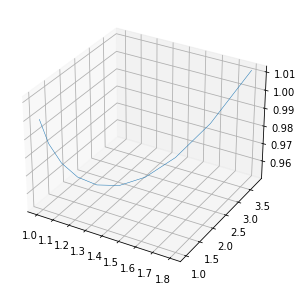

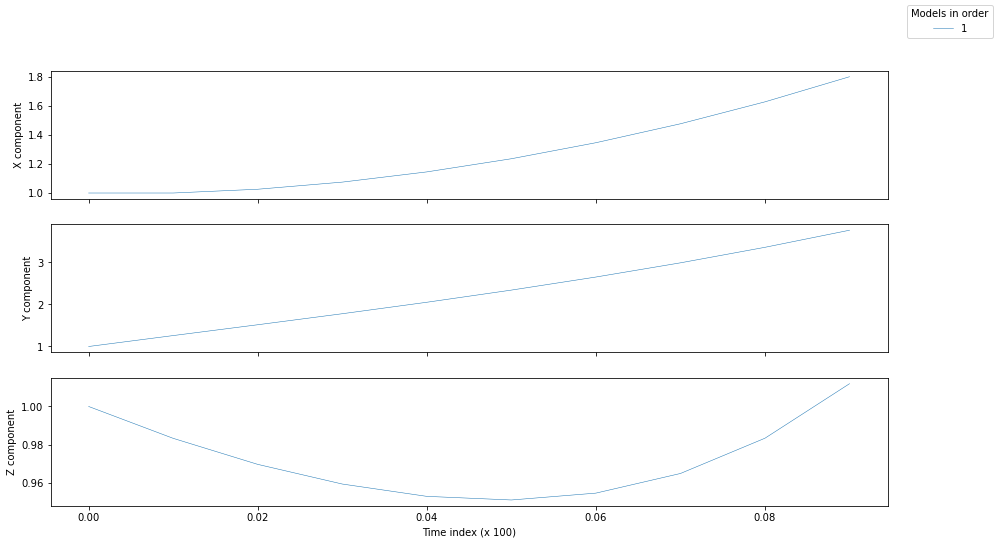

In [10]:
l63, l63_timeline = generate_lorenz(
    start_time=model_start, 
    number_of_samples=10
)
plot_model(l63, l63_timeline)

## Task 2. Have fun with 4dvar

So you know how to sample L63 trajectory. Now you will use 4D-Var to predict Lorenz64 parameters.
Find out how many samples are needed so we can say that the prediction is satisfying enough. As stated before, `number_of_samples` should be less than `200`, otherwise the prediction would have taken too much time.
Try few options each one in new cell so you can compare your results. \
TIP: play on range [5, 200]. \
Put `;` on the end of the method, it disables auto printing of returned value.

  Intermediate CurrentState at the current iteration: [ 1.  1.  1. 20. 10.  5.]
  Intermediate CurrentState at the current iteration: [ 1.64475722  1.76060675  1.06080918 20.04411502 10.00955922  4.99450086]
  Intermediate CurrentState at the current iteration: [ 1.18997542  1.22411008  1.01791721 20.01299833 10.00281659  4.9983797 ]
  Intermediate CurrentState at the current iteration: [ 1.18152702  1.23152999  1.03162057 20.01620771 10.00269848  4.99725196]
  Intermediate CurrentState at the current iteration: [ 1.11859226  1.28699731  1.08185632 20.04770229 10.0019385   4.98928602]
  Intermediate CurrentState at the current iteration: [ 1.10385227  1.29925735  1.07861199 20.07000928 10.0020782   4.98509538]
  Intermediate CurrentState at the current iteration: [ 1.08242843  1.31415082  1.07433251 20.15603936 10.00345865  4.96826828]
  Intermediate CurrentState at the current iteration: [ 1.04341409  1.33343989  1.06630207 20.46385076 10.00939808  4.90737749]
  Intermediate CurrentSt

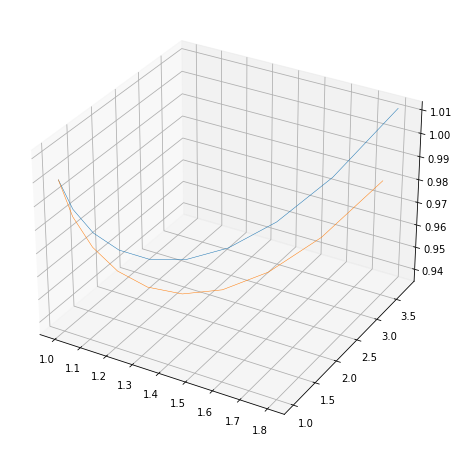

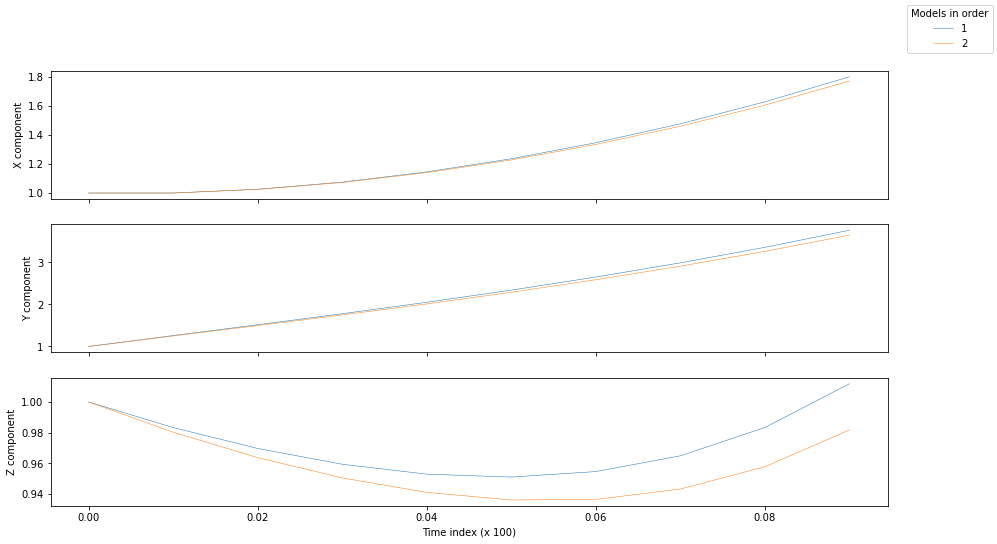

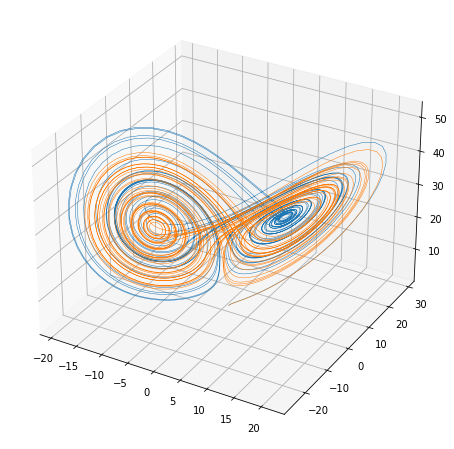

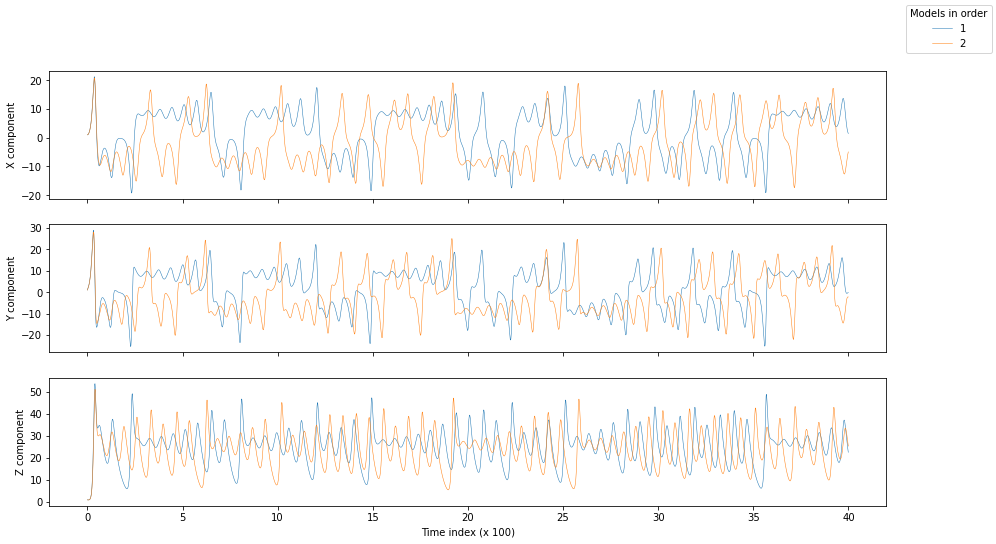

In [12]:
lorenz_research(
    number_of_samples=10,
# TODO: use stating point that you have chossen in previous task
    start_time=0
);

## Task 3. Play with iterations

4D-Var assimilation does iterations and during each one it gets closer to the solution. Try to optimize it, just like samples .


  Intermediate CurrentState at the current iteration: [ 1.  1.  1. 20. 10.  5.]
  Intermediate CurrentState at the current iteration: [ 1.64475722  1.76060675  1.06080918 20.04411502 10.00955922  4.99450086]
  Intermediate CurrentState at the current iteration: [ 1.18997542  1.22411008  1.01791721 20.01299833 10.00281659  4.9983797 ]
  Intermediate CurrentState at the current iteration: [ 1.18152702  1.23152999  1.03162057 20.01620771 10.00269848  4.99725196]
  Intermediate CurrentState at the current iteration: [ 1.11859226  1.28699731  1.08185632 20.04770229 10.0019385   4.98928602]
  Intermediate CurrentState at the current iteration: [ 1.10385227  1.29925735  1.07861199 20.07000928 10.0020782   4.98509538]
  Intermediate CurrentState at the current iteration: [ 1.08242843  1.31415082  1.07433251 20.15603936 10.00345865  4.96826828]
  Intermediate CurrentState at the current iteration: [ 1.04341409  1.33343989  1.06630207 20.46385076 10.00939808  4.90737749]
  Intermediate CurrentSt

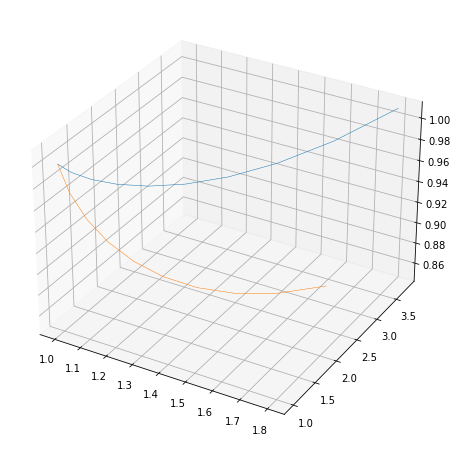

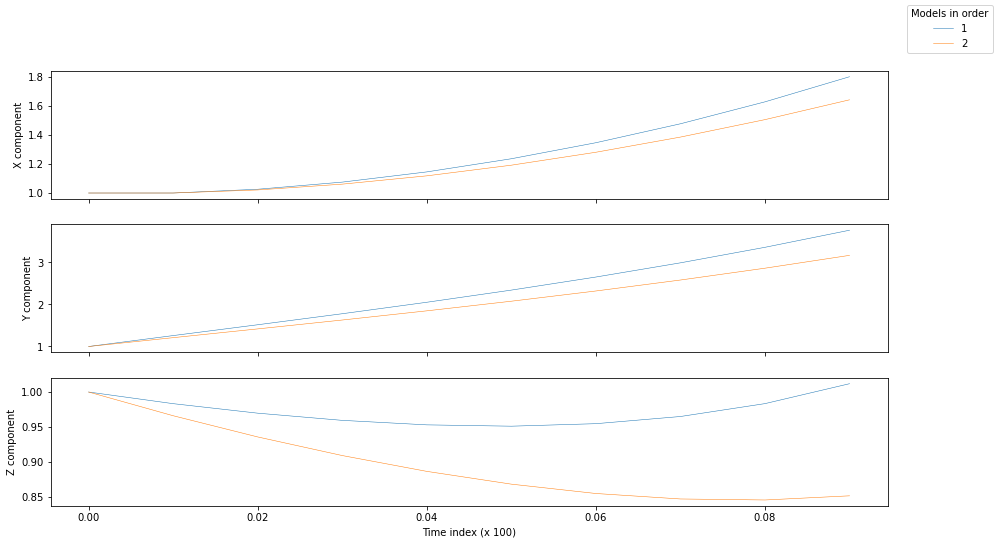

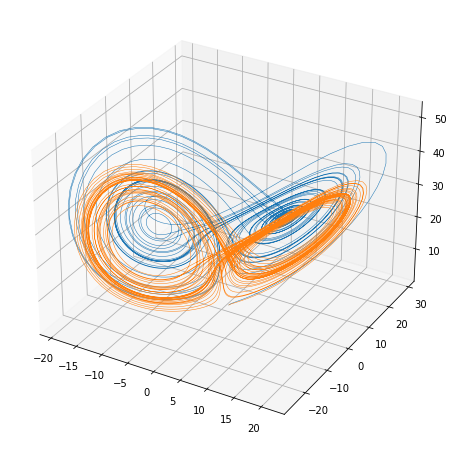

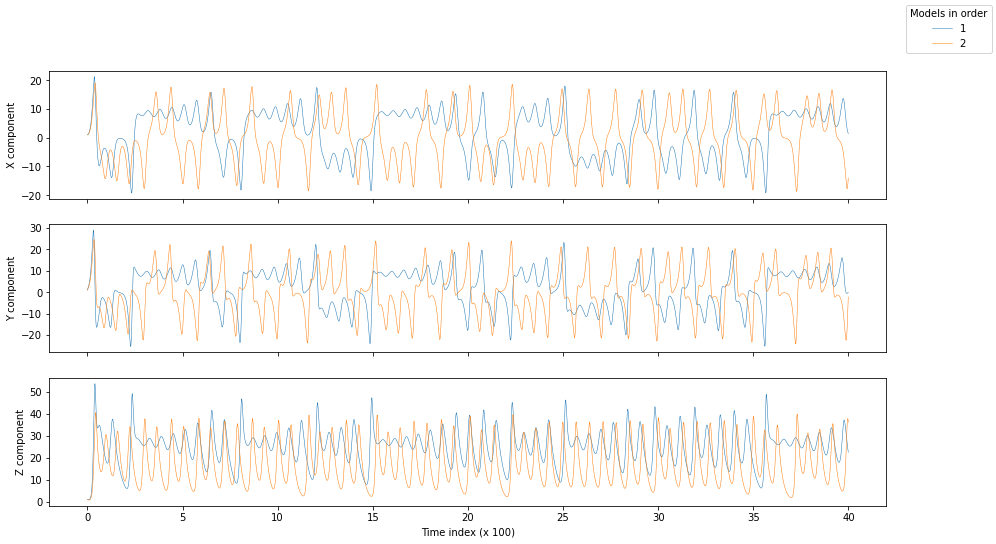

In [31]:
lorenz_research(
    number_of_samples=10,
    steps_4dvar=10,
    start_time=0
);

## Task 4. Create submodels

Now we will use the idea that some pretrained models can be connected to create new, better one. In this task you have to create 3 submodels with chosen by you \
init values. We hope you have some intuition after previous tasks so you can chose them wisely.

In [27]:
submodel_creator = set_submodel_consts(
    number_of_samples = 25,
    steps_4dvar = 10,
)

  Intermediate CurrentState at the current iteration: [ 8.88616658  6.09143734 30.72027943 20.         10.          5.        ]
  Intermediate CurrentState at the current iteration: [ 8.80781691  6.68937628 30.93999243 20.24325779  9.98635068  4.27288523]
  Intermediate CurrentState at the current iteration: [ 8.28673036  8.45398166 30.99421387 21.22664611  9.97681774  2.74847195]
  Intermediate CurrentState at the current iteration: [ 8.14581487  8.45566667 30.74654809 21.41472494  9.97757205  3.00805639]
  Intermediate CurrentState at the current iteration: [ 8.0562948   8.47112696 30.61406243 21.64299943  9.97836338  3.00687422]
  Intermediate CurrentState at the current iteration: [ 7.94746336  8.28983104 30.37302878 22.23338355  9.980959    2.90256497]
  Intermediate CurrentState at the current iteration: [ 7.91920148  7.64972715 29.94228238 23.72752644  9.98413705  2.58701431]
  Intermediate CurrentState at the current iteration: [ 8.44517565  6.84819393 29.80658721 26.12472951  

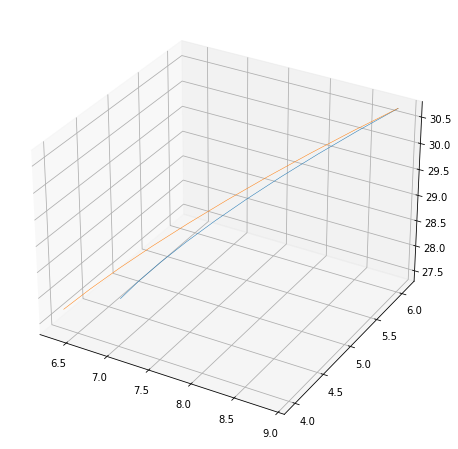

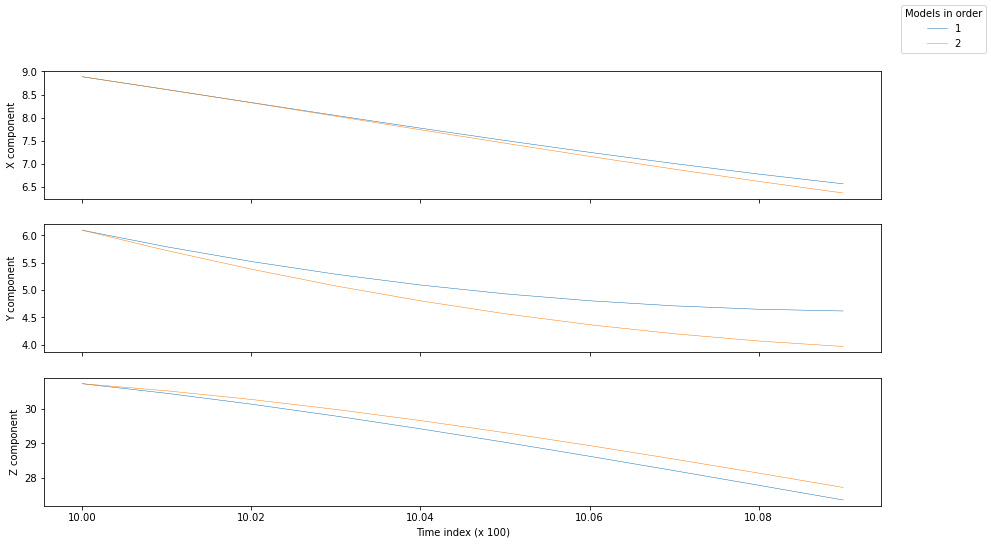

In [76]:
sm1 = submodel_creator(
    sigma=10,
    rho=20,
    beta=5,
    start_time=10
)

  Intermediate CurrentState at the current iteration: [ 1.  1.  1. 20. 16.  5.]
  Intermediate CurrentState at the current iteration: [ 1.53429926  1.84088007  1.0709972  20.04832657 16.00548675  4.99376774]
  Intermediate CurrentState at the current iteration: [ 1.12053856  1.18970356  1.01601705 20.01090253 16.00123782  4.99859399]
  Intermediate CurrentState at the current iteration: [ 1.11183357  1.19557754  1.02965063 20.01365761 16.00042224  4.9975307 ]
  Intermediate CurrentState at the current iteration: [ 1.03184987  1.24996222  1.08986097 20.04461672 15.99131766  4.98903373]
  Intermediate CurrentState at the current iteration: [ 1.0019913   1.26986071  1.08629815 20.06798354 15.98441417  4.98456586]
  Intermediate CurrentState at the current iteration: [ 0.97844259  1.2837083   1.08016061 20.12956934 15.96608061  4.97224799]
  Intermediate CurrentState at the current iteration: [ 0.93808382  1.30263121  1.06841816 20.34950169 15.90040601  4.92742036]
  Intermediate CurrentSt

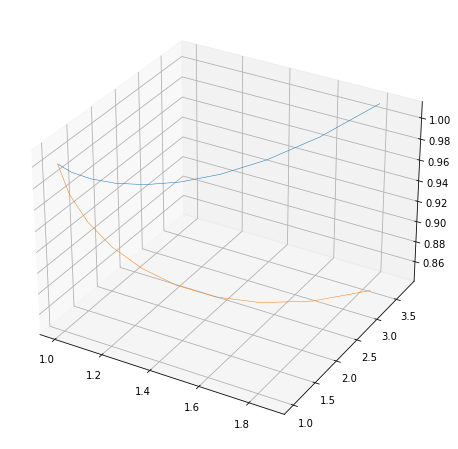

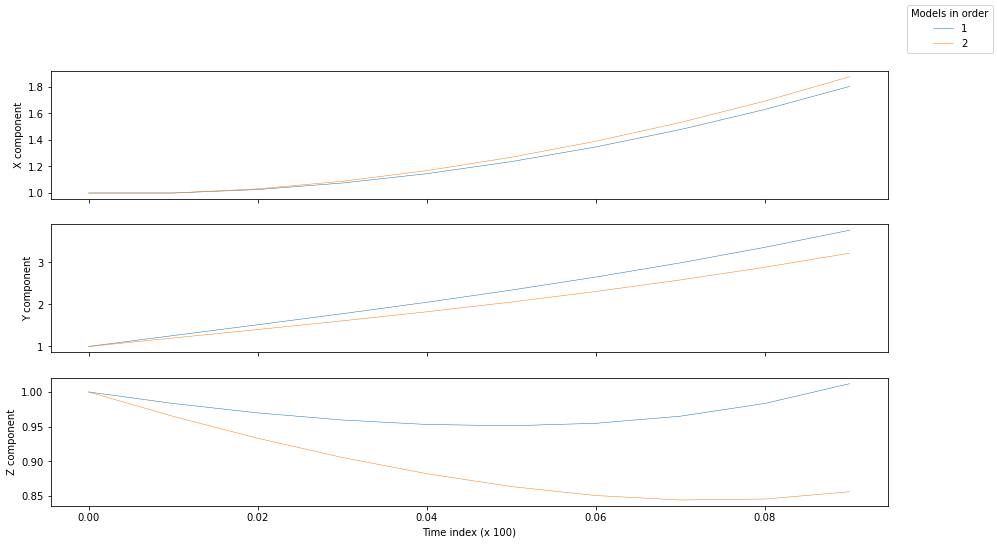

In [78]:
sm2 = submodel_creator(
    sigma=16,
    rho=20,
    beta=5,
    start_time=0
)

  Intermediate CurrentState at the current iteration: [-13.8599078  -17.59232051  30.08071221   8.          16.
  32.        ]
  Intermediate CurrentState at the current iteration: [-13.80446334 -18.38239466  30.1025981    8.40312307  15.9736244
  31.54280653]
  Intermediate CurrentState at the current iteration: [-13.58268549 -21.54269128  30.19014165  10.01561536  15.868122
  29.71403267]
  Intermediate CurrentState at the current iteration: [-18.07418205 -52.39922867  34.55931367  24.9354109   16.7963249
  -0.92635971]
  Intermediate CurrentState at the current iteration: [-13.8684208  -23.5056901   30.46809505  10.96476726  15.92717144
  27.76478434]
  Intermediate CurrentState at the current iteration: [-16.64422322 -42.57542556  33.16829934  20.18539206  16.50081273
   8.82862926]
  Intermediate CurrentState at the current iteration: [-14.67133389 -29.02169513  31.24914104  13.63187362  16.09309971
  22.28741803]
  Intermediate CurrentState at the current iteration: [-18.43598288

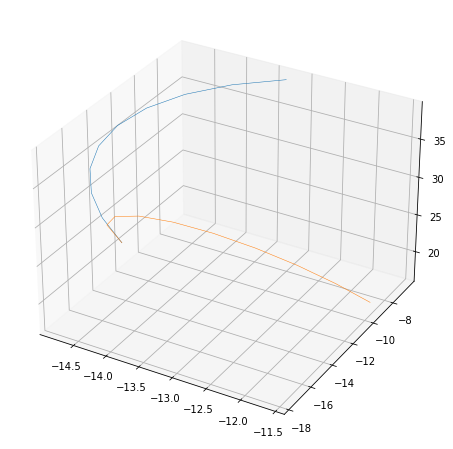

ValueError: x and y must have same first dimension, but have shapes (11,) and (10,)

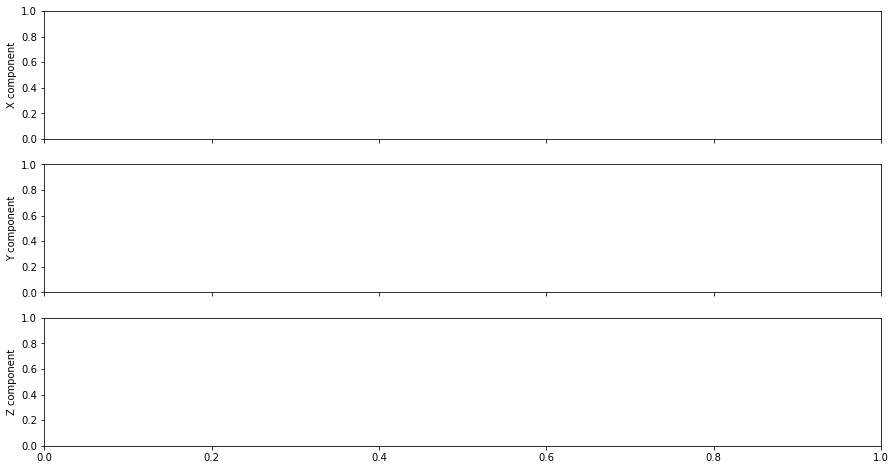

In [79]:
sm3 = submodel_creator(
    sigma=16,
    rho=8,
    beta=32,
    start_time=20
)

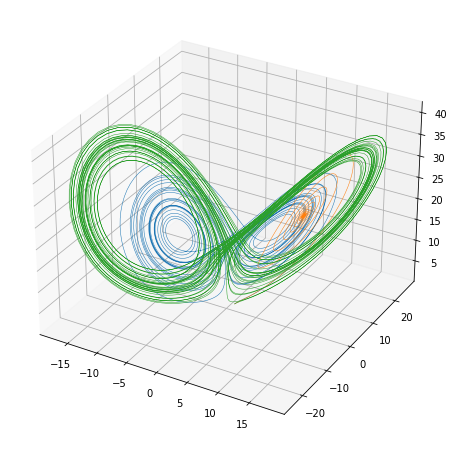

0.042062535112129616
0.04046577742953903
0.04060325270534555


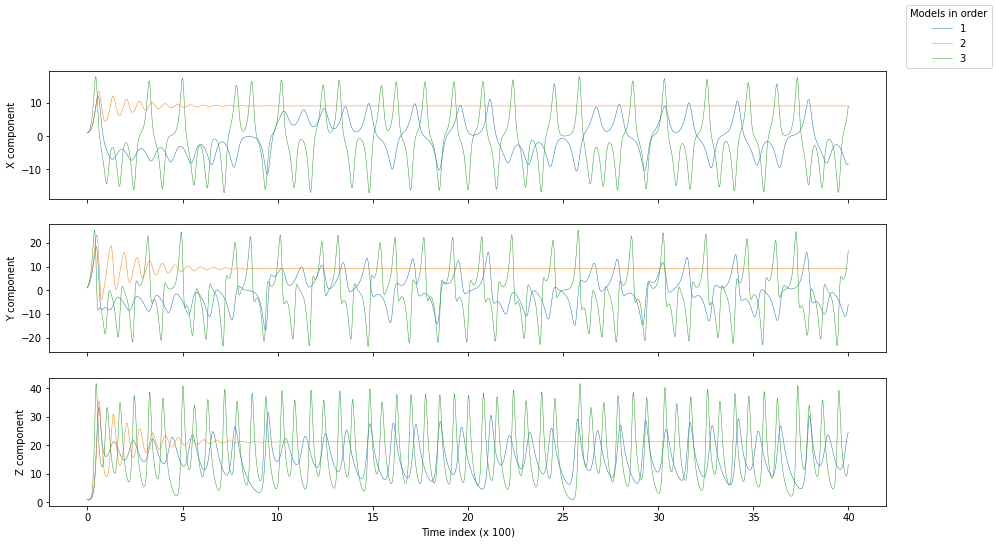

In [67]:
plot_models([
    sm1['full']['pred'][0],
    sm2['full']['pred'][0],
    sm3['full']['pred'][0],
],
[
    sm1['full']['pred'][1],
    sm2['full']['pred'][1],
    sm3['full']['pred'][1],
]
)

print(error_metric(sm1['full']['gt'][0], sm1['full']['pred'][0]))
print(error_metric(sm2['full']['gt'][0], sm2['full']['pred'][0]))
print(error_metric(sm3['full']['gt'][0], sm3['full']['pred'][0]))


0.03610799706328104


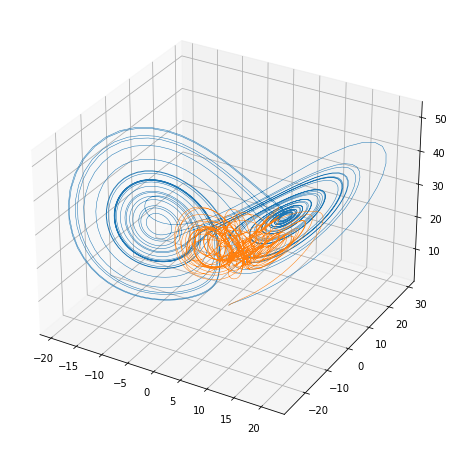

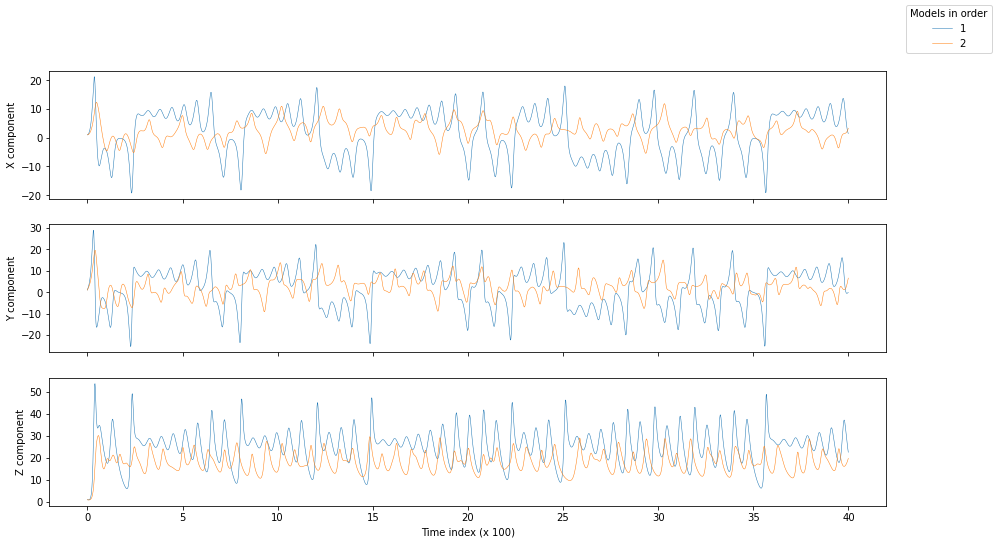

In [68]:
mean_submodel = calc_mean_lorenz(np.array([
    sm1['full']['pred'][0],
    sm2['full']['pred'][0],
    sm3['full']['pred'][0],
]))

print(error_metric(sm1['full']['gt'][0],mean_submodel))
plot_models([sm1['full']['gt'][0], mean_submodel], [sm1['full']['gt'][1], sm1['full']['gt'][1]])

## Task 5. Mean average from submodels

Some times one of your model can be better than others so its importance might be higher than others. Try to find best weights for weight average of your submodels.

In [ ]:
weights = [?,?,?]

mean_submodel = calc_weighted_average_lorenz(np.array([
        sm1['full']['pred'][0],
        sm2['full']['pred'][0],
        sm3['full']['pred'][0],
    ]),
    weights
)

plot_models([sm1['full']['gt'][0], mean_submodel], [sm1['full']['gt'][1], sm1['full']['gt'][1]])

## Task 6. 3d-var for weighted average from submodels

Now try to use 3D-Var to find best weights

In [69]:
def obertvator_kind(kind):
    def observator(weights):
        return calc_weighted_average_lorenz(np.array([
                sm1[kind]['pred'][0],
                sm2[kind]['pred'][0],
                sm3[kind]['pred'][0],
            ]),
            list(np.ravel(weights))
        )
    return observator


  Intermediate CurrentState at the current iteration: [1. 1. 1.]
  Intermediate CurrentState at the current iteration: [0.65486892 1.81339579 0.5317353 ]
  Intermediate CurrentState at the current iteration: [0.59206975 1.78394183 0.74661042]
  Intermediate CurrentState at the current iteration: [0.5289713  1.81025939 0.77070979]
  Intermediate CurrentState at the current iteration: [0.51449822 1.816979   0.77296323]
  Intermediate CurrentState at the current iteration: [0.51476477 1.81695283 0.77272224]
  Intermediate CurrentState at the current iteration: [0.51476893 1.81696041 0.77270169]
Calibration of 3 coefficients on 12000 measures
---------------------------------------------------------------------
Calibration resulting coefficients.: [0.51476893 1.81696041 0.77270169]
  Intermediate CurrentState at the current iteration: [1. 1. 1.]
  Intermediate CurrentState at the current iteration: [1.79454222 0.76560001 0.43985778]
  Intermediate CurrentState at the current iteration: [ 2

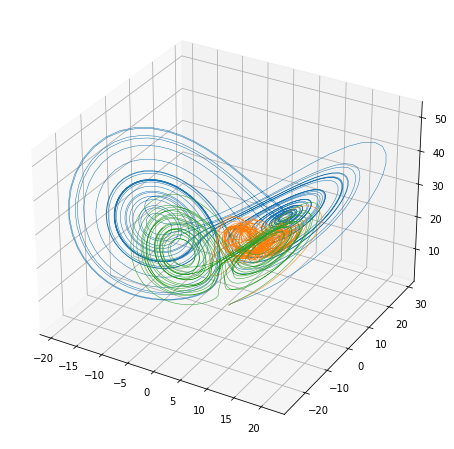

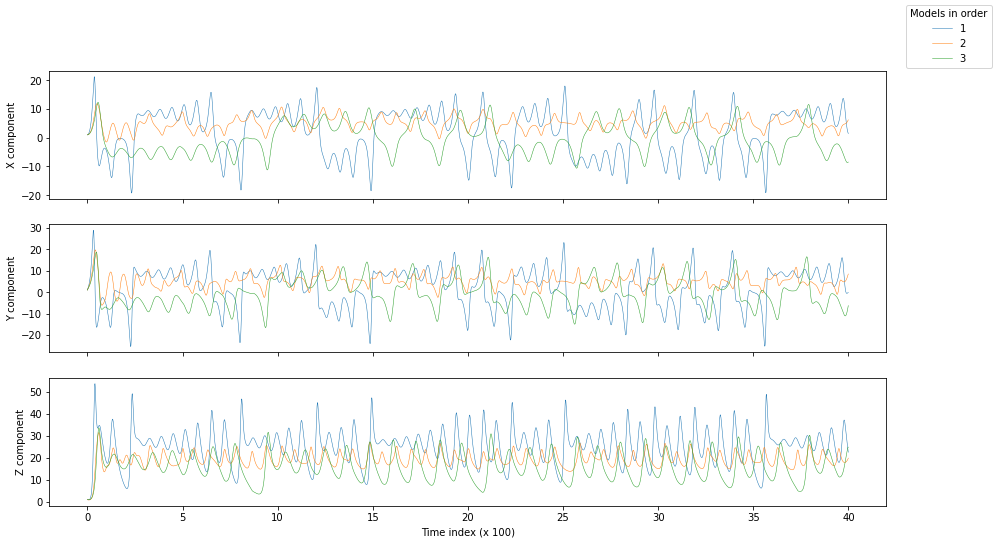

In [74]:
predicted_weights_full = assimilate_lorenz_weighted([1.,1.,1.], sm1['full']['gt'][0], obertvator_kind('full'))
predicted_weights_partial = assimilate_lorenz_weighted([1.,1.,1.], sm1['partial']['gt'][0], obertvator_kind('partial'))



weighted_avg_on_full = calc_weighted_average_lorenz(
    np.array([
            sm1['full']['pred'][0],
            sm2['full']['pred'][0],
            sm3['full']['pred'][0],
        ]),
    predicted_weights_full
    )

weighted_avg_on_partial = calc_weighted_average_lorenz(
    np.array([
            sm1['full']['pred'][0],
            sm2['full']['pred'][0],
            sm3['full']['pred'][0],
        ]),
    predicted_weights_partial
    )

print(error_metric(sm1['full']['gt'][0], weighted_avg_on_full))
print(error_metric(sm1['full']['gt'][0], weighted_avg_on_partial))

plot_models(
    [sm1['full']['gt'][0],
     weighted_avg_on_full, 
     weighted_avg_on_partial], 
    [sm1['full']['gt'][1],
     sm1['full']['gt'][1],
     sm1['full']['gt'][1]]
)

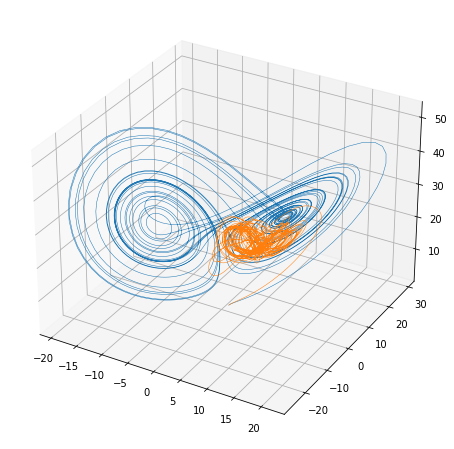

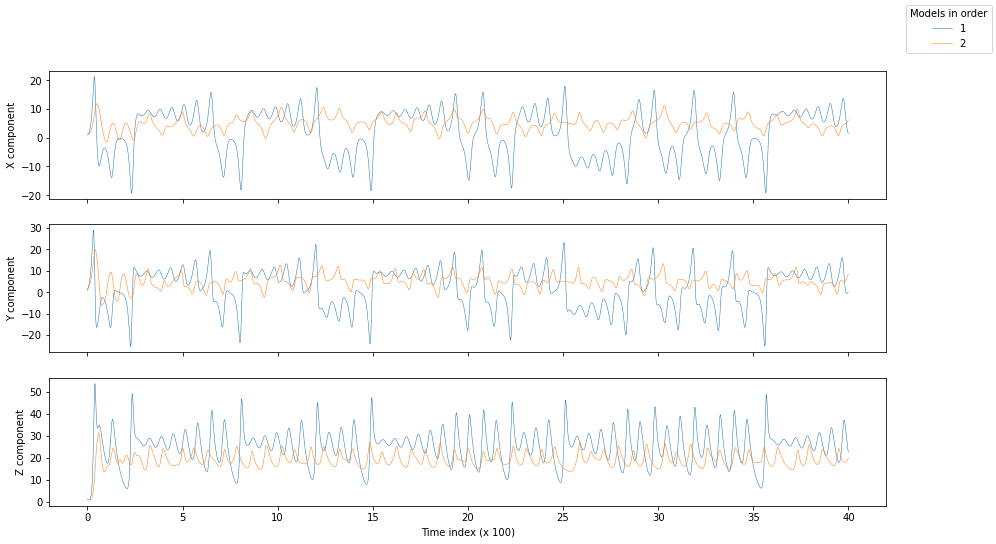

In [75]:
plot_models(
    [sm1['full']['gt'][0],
    weighted_avg_on_full # put here your best weighted avg supermodel
    ], 
    [sm1['full']['gt'][1],
     sm1['full']['gt'][1]]
)

## Task 7. Supermodeling

![](images/coupling.png)

source: Complex Systems Lecture

In [ ]:
def super_model_observator_kind(kind):
    def observator(springs):
        c12, c13, c21, c23, c31, c32 = list(np.ravel(springs))
        m1 = sm1[kind]['pred'][0].copy()
        m2 = sm2[kind]['pred'][0].copy()
        m3 = sm3[kind]['pred'][0].copy()
        x1 = m1[:, 0]
        x2 = m2[:, 0]
        x3 = m3[:, 0]
        m1[:, 0] += ???
        m2[:, 0] += ???
        m3[:, 0] += ???

        return calc_mean_lorenz(np.array([m1, m2,m3,]))
    return observator


predicted_springs_for_x = assimilate_lorenz_weighted([1., 1., 1., 1., 1., 1.], sm1['full']['gt'][0], super_model_observator_kind('full'))

In [ ]:
mean_submodel = calc_mean_lorenz(np.array([
    sm1['full']['pred'][0],
    sm2['full']['pred'][0],
    sm3['full']['pred'][0],
]))

In [ ]:
springed_values = obertvator_kind('full')(predicted_springs_for_x)
plot_models(
    [sm1['full']['gt'][0],
    springed_values,
     mean_submodel,
    ],
    [sm1['full']['gt'][1],
     sm1['full']['gt'][1],
     sm1['full']['gt'][1]]
)